# Домашнее задание #4 по MADE: ML
Разработчики: Иванов А.В и Горяев А.

<b>Задание:</b> Необходимо разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д).

<b>Метрика качества:</b>  GINI = roc_auc * 2 - 1 - метрика качества, которая часто используется при оценке предсказательных моделей в задачах бинарной классификации в условиях сильной несбалансированности классов целевой переменной. Именно она широко применяется в задачах банковского кредитования, страхования и целевом маркетинге.

## Импортируем библиотеки

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [65]:
import warnings
warnings.simplefilter('ignore')

In [66]:
RANDOM_STATE = 42

## Подгружаем данные

Генеральная совокупность данных делиться на следующие выборки:
  <ul>
   <li><b>DEV</b> - выборка для разработки модели</li>
   <li><b>OOT</b> (out of time) - максимально свежие данные, предназанченные для тестирвования/валидации с целью понимания, что было бы если бы мы модель использовали сейчас.</li>
   <li><b>OOS</b> (out of samle) - выборка предназанченная для тестирования/валидации, совпадающая по временому горизонту с выборкой для разработки. Формирование выборки OOS произовдится со стратификацией уровня дефолта относительно DEV</li>
  </ul>
<p><img src="https://dsbattle.com/assets/images/dev-oos-oot.png" width="700" alt="lorem"></p>

<i>Стратификация — метод выбора подмножества объектов из генеральной совокупности, разбитой на подмножества (страты). При стратификации объекты выбираются таким образом, чтобы итоговая выборка сохраняла соотношения размеров страт.</i>

Данные были взяты с хакатона https://dsbattle.com/hackathons/juniords/ ( тест для данной работы не используем).

https://raw.githubusercontent.com/BKHV/ds-test/master/PD-data-train.csv

In [67]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')

Семплы и размеры выборок

In [68]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


In [69]:
train_df.shape

(32395, 37)

Уровень дефолт-рейта в выборке = 6,4547%

In [70]:
train_df['default_12m'].values.mean()

0.06454699799351751

## Сгенерируем новые относительные признаки

In [71]:
df = train_df.copy()

TL = df.ab_long_term_liabilities + df.ab_other_borrowings + df.ab_short_term_borrowing
TA = df.ab_own_capital + df.ab_borrowed_capital
STD = df.ab_short_term_borrowing
STFD = df.ab_short_term_borrowing
CA = df.ab_mobile_current_assets
FCA = df.ab_mobile_current_assets - df.ab_inventory
GY = df.ar_sale_profit

df['r_1_a'] = df.ar_revenue / (df.ab_accounts_receivable/12)
df['r_2_a'] = df.ar_sale_cost / (df.ab_inventory/12)
df['r_3_a'] = df.ar_selling_expenses / (df.ar_total_expenses/12)
df['r_4_a'] = df.ar_revenue / TA -TL
df['r_5_a'] = df.ar_revenue / (df.ab_immobilized_assets/12)
df['r_6_a'] = df.ar_revenue / (df.ab_mobile_current_assets + df.ab_cash_and_securities)
df['r_7_a'] = df.ar_sale_profit / df.ar_revenue
df['r_8_a'] = df.ar_profit_before_tax / df.ar_revenue
df['r_9_a'] = df.ar_net_profit / df.ar_revenue

df['r_10_a'] = df.ab_short_term_borrowing / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_11_a'] = df.ab_accounts_payable / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_12_a'] = df.ab_inventory / df.ar_revenue
df['r_13_a'] = df.ab_long_term_liabilities / df.ar_revenue
df['r_15_a'] = df.ar_taxes / df.ar_revenue

df['r_16_a'] = df.ab_inventory / df.ab_borrowed_capital
df['r_17_a'] = df.ab_inventory / df.ab_mobile_current_assets
df['r_18_a'] = df.ab_inventory / df.ab_accounts_payable

df['r_19_a'] = df.ab_accounts_receivable / (df.ab_cash_and_securities + df.ab_accounts_receivable)
df['r_20_a'] = df.ab_cash_and_securities / df.ab_borrowed_capital
df['r_21_a'] = df.ab_cash_and_securities / df.ab_short_term_borrowing
df['r_22_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable)
df['r_23_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable + df. ab_other_borrowings)

df['r_24_a'] = df.ar_profit_before_tax / df.ar_net_profit

df['r_25_a'] = TL / TA
df['r_26_a'] = (df.ab_accounts_receivable + df.ab_cash_and_securities) / TA
df['r_27_a'] = CA / STD


все абсолютные признаки убираем кроме чистой прибыли, оставляем только относительные признаки

Также убираем признак ul_systematizing_flg так как у нее единственное значение на всей выборке

In [72]:
df_short = df.drop(
    [
        'ar_revenue',
        'ar_total_expenses',
        'ar_sale_cost',
        'ar_selling_expenses',
        'ar_management_expenses',
        'ar_sale_profit',
        'ar_balance_of_rvns_and_expns',
        'ar_profit_before_tax',
        'ar_taxes',
        'ar_other_profit_and_losses',
        'ul_systematizing_flg'
    ], axis = 1)

Преобразуем категориальный признак 'ul_staff_range'. В данном случае можно категории просто заменить на числа,сохраняя порядок, так как для категорий данного признака поряд задан.

In [73]:
df_short['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [74]:
df_short.loc[df_short['ul_staff_range'] == '[1-100]', 'ul_staff_range'] = 1
df_short.loc[df_short['ul_staff_range'] == '(100-500]', 'ul_staff_range'] = 2
df_short.loc[df_short['ul_staff_range'] == '> 500', 'ul_staff_range'] = 3

In [75]:
train_df_new = df_short

Существует два подоха к выбору объекта оценки:
  <ul>
   <li><b>Розничный</b> (портфельный) - моделирование проводится на уровне кредитного требования (кредита).</li>
   <li><b>Корпоративный</b> (индивидуальный) - моделирование проводится на уровне субъекта (клиента).</li>
  </ul>
В текущем задании применим корпоративный подход и выполним моделирование на уровне клиента. Дубликаты с разным record_id, но одинаковыми остальными значениями признаков. Удаляем их из трейна

In [76]:
column_list = list(train_df_new.columns)
subset = column_list.copy()
subset.remove('record_id')

train_df_new.drop_duplicates(subset=subset, inplace = True)
train_df_new.drop(['record_id'], axis = 1, inplace = True)

Разбиваем на 2 выборки по наличию финансовой отчетности.
Юридические лица в обязательном порядке в стандартизированной форме подают отчётность в налоговую,
в отличие от индивидуальных предпринимателей.

In [77]:
train_df_ip = train_df_new[train_df_new['ar_net_profit'].isnull()]
train_df_ul = train_df_new[~train_df_new['ar_net_profit'].isnull()]

In [78]:
train_df_ip.shape

(10215, 51)

In [79]:
train_df_ul.shape

(16375, 51)

Удалим столбцы в которых есть пропуски для данных без фин отчетности

In [80]:
nan_column_ip = train_df_ip.columns[train_df_ip.isnull().any()]

In [81]:
train_df_ip.drop(nan_column_ip, axis = 1, inplace = True)

Пропуски в таблице с фин отчетностью только в новых признаках.
Заполним их нулями.

In [82]:
train_df_ul.fillna(0, inplace = True)

## Модель для данных без фин отчетности

Разобьем данные на тестовую и обучающую выборки

In [83]:
X_ip = train_df_ip.drop(['default_12m'], axis = 1)
y_ip = train_df_ip['default_12m']

In [84]:
X_ip['ul_strategic_flg'].value_counts()

0    10215
Name: ul_strategic_flg, dtype: int64

Удаляем этот признак, так как он является константым для данных без фин отчетности.

In [85]:
X_ip.drop(['ul_strategic_flg'], axis = 1, inplace = True)
X_ip['ul_capital_sum'] = X_ip['ul_capital_sum'].astype(int)
X_ip['ul_staff_range'] = X_ip['ul_staff_range'].astype(int)
y_ip = y_ip.astype(int)

Разбиваем размеченные данные на обучающую и валидационную выборки

In [86]:
X_train_ip, X_test_ip, y_train_ip, y_test_ip = train_test_split(X_ip, y_ip, test_size=0.3, random_state=42)

### WOE
Для бинаризации признаков будет использовать библиотеку riskpy
(pip install git+https://github.com/Falconwatch/riskpy.git@master)

Для лёгкой интерпритации результатов используем монотонное преобразование.

In [87]:
from riskpy.modeling.binning import Binner
from riskpy.graphs.graphs import binning_barchart

Для работы библиотеки riskpy необходимо добавить таргет в данные

In [88]:
X_train_ip['default_12m'] = y_train_ip
X_test_ip['default_12m'] = y_test_ip
X_ip['default_12m'] = y_ip

In [89]:
binner_ip = Binner()
bins = binner_ip.fit(X_train_ip, 'default_12m')
X_train_woe_ip = binner_ip.transform(X_train_ip)
X_test_woe_ip = binner_ip.transform(X_test_ip)

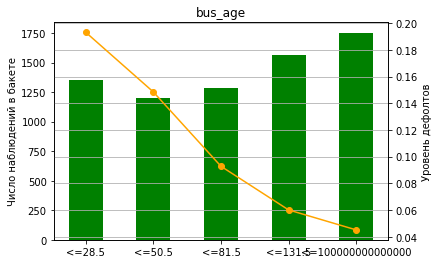

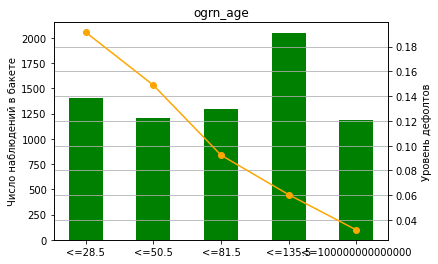

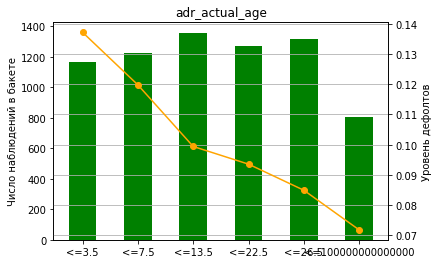

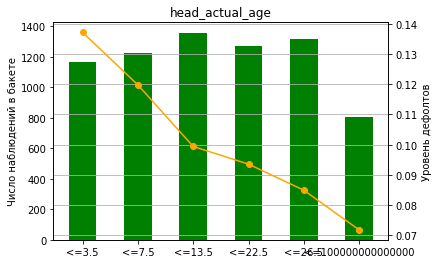

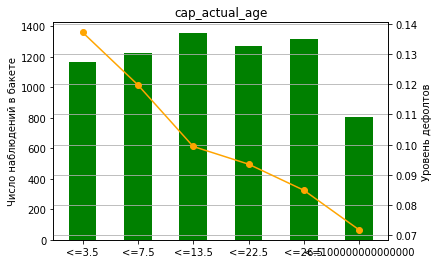

No binning for variable ul_staff_range
No binning for variable ul_branch_cnt


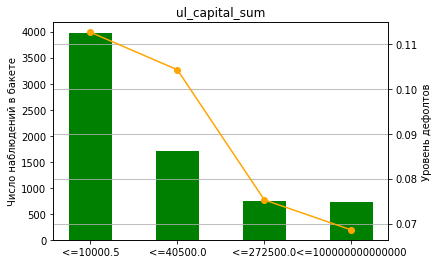

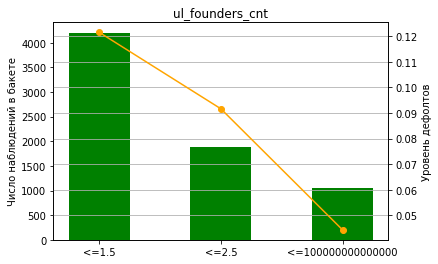

In [90]:
binning_barchart(bins)

### Отбор признаков


In [91]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

Экспериментально было подобрано, что 4 признака в данной задаче для данных без фин отчетности является оптимальным и позволяет убрать все коррелирующие признаки

In [92]:
FEATURE_COUNT = 4
N_SPLITS = 3

In [93]:
y_train_woe_ip = X_train_woe_ip['default_12m']
y_test_woe_ip = X_test_woe_ip['default_12m']
X_train_woe_ip.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_ip.drop(['default_12m'], axis = 1, inplace = True)

Запустим метод  Forward Selection для отбора признаков.

In [94]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT , 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_ip, y_train_woe_ip)

Выведем отобранные признаки

In [95]:
selector.subsets_[4]

{'feature_idx': (1, 2, 5, 6),
 'cv_scores': array([0.68657404, 0.7199425 , 0.69490493]),
 'avg_score': 0.700473822683326,
 'feature_names': ('ogrn_age_woe',
  'adr_actual_age_woe',
  'ul_capital_sum_woe',
  'ul_founders_cnt_woe')}

Построим карту корреляций для выбранных признаков.

In [96]:
top_feat = list(selector.subsets_[FEATURE_COUNT]['feature_names'])
X_train_woe_ip[top_feat].corr()

,ogrn_age_woe,adr_actual_age_woe,ul_capital_sum_woe,ul_founders_cnt_woe
ogrn_age_woe,1.000000,0.150301,0.074962,0.061599
adr_actual_age_woe,0.150301,1.000000,-0.064346,-0.017928
ul_capital_sum_woe,0.074962,-0.064346,1.000000,0.078222
ul_founders_cnt_woe,0.061599,-0.017928,0.078222,1.000000


Все корреляции меньше 0.5. <br>Эффективность моделей бинарной классификации наилучшим образом оценивает метрика ROC/AUC (<b>Gini</b>). Поэтому оценим значимость каждого признака, вычислив коэффициент <b>Gini</b>.

In [97]:
gini_features = pd.DataFrame(index=top_feat, columns = ['Gini'])
for feat in top_feat:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_ip.loc[:, feat].values.reshape(-1,1), y_train_woe_ip)
    preds_train = logreg.predict_proba(X_train_woe_ip.loc[:, feat].values.reshape(-1,1))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_ip, preds_train) - 1

In [98]:
gini_features

,Gini
ogrn_age_woe,0.345307
adr_actual_age_woe,0.125302
ul_capital_sum_woe,0.080751
ul_founders_cnt_woe,0.144248


In [99]:
X_train_woe_ip_final = X_train_woe_ip[top_feat]
X_test_woe_ip_final = X_test_woe_ip[top_feat]

### Подбираем коэффициент регуляризации

In [100]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_ip_final, y_train_woe_ip):
        
        X_train, X_test = X_train_woe_ip_final.iloc[train_index,:], X_train_woe_ip_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_ip.iloc[train_index], y_train_woe_ip.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

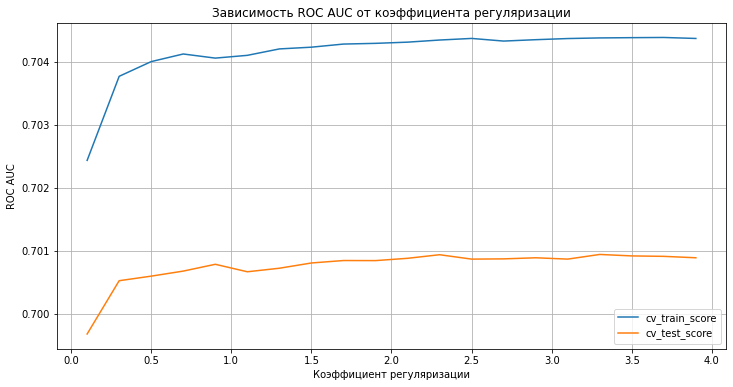

In [101]:
plt.plot(alphas, cv_scores_train, label = 'cv_train_score')
plt.plot(alphas, cv_scores_test, label = 'cv_test_score')
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.legend()
plt.title('Зависимость ROC AUC от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('ROC AUC')
plt.show()

In [102]:
print("Наилучший коэффициент L2 - регуляризации:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент L2 - регуляризации: 3.3000000000000007


### Строим Лассо регрессию

Обучаем модель на всей обучащей выборке (без валидации)

In [103]:
logreg_ip = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.3)
logreg_ip.fit(X_train_woe_ip_final, y_train_woe_ip)
y_pred = logreg_ip.predict_proba(X_test_woe_ip_final)[:,1]
y_pred_train = logreg_ip.predict_proba(X_train_woe_ip_final)[:,1]
print("Gini val:", roc_auc_score(y_test_woe_ip, y_pred) * 2 - 1)
print("Gini train:", roc_auc_score(y_train_woe_ip, y_pred_train) * 2 - 1)

Gini val: 0.40015790436367094
Gini train: 0.4079264938711149


## Модель для данных с фин отчетностью

Проделаем аналогичные действия для данных с фин отчетностью.

In [104]:
train_df_ul['ul_strategic_flg'].value_counts()

0    16372
1        3
Name: ul_strategic_flg, dtype: int64

Убираем ul_strategic_flg так как практически константная переменная, убираем ul_branch_cnt так как не биннаризуется

In [105]:
train_df_ul.drop(['ul_strategic_flg', 'ul_branch_cnt'], axis = 1, inplace = True)

In [106]:
train_df_ul = train_df_ul.astype('float32')
train_df_ul = train_df_ul.replace([np.inf, -np.inf], 0)
X_ul = train_df_ul.drop(['default_12m'], axis = 1)
y_ul = train_df_ul['default_12m']

Разделяем данные на обучающую и валидационную выборки

In [107]:
X_train_ul, X_test_ul, y_train_ul, y_test_ul = train_test_split(X_ul, y_ul, test_size=0.3, random_state=RANDOM_STATE)

In [108]:
X_train_ul['default_12m'] = y_train_ul
X_test_ul['default_12m'] = y_test_ul

Проводим бинаризацию признаков

In [109]:
binner_ul = Binner()
bins = binner_ul.fit(X_train_ul, 'default_12m')
X_train_woe_ul = binner_ul.transform(X_train_ul)
X_test_woe_ul = binner_ul.transform(X_test_ul)

Выведем результат бинаризации

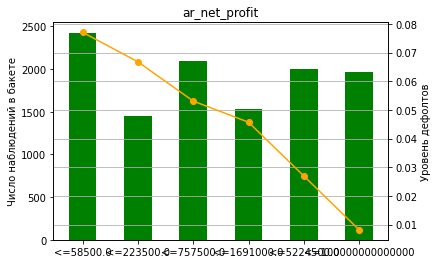

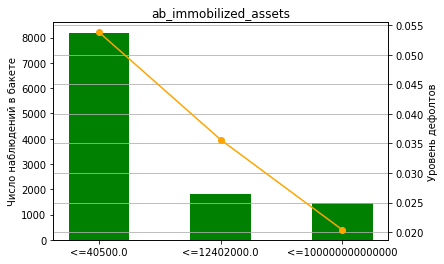

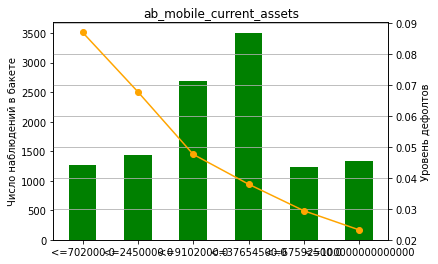

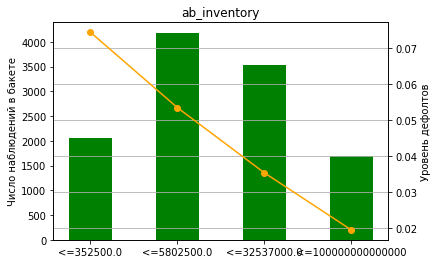

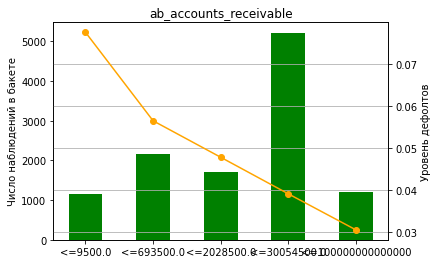

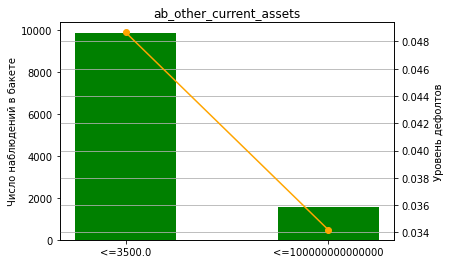

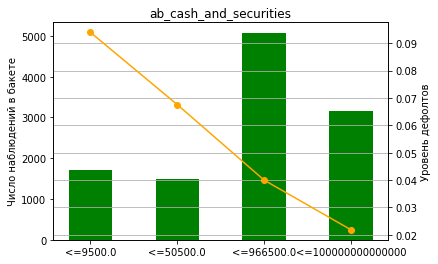

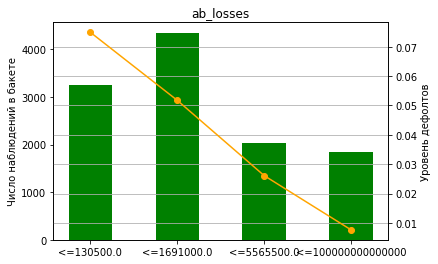

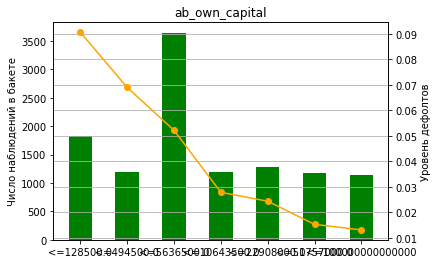

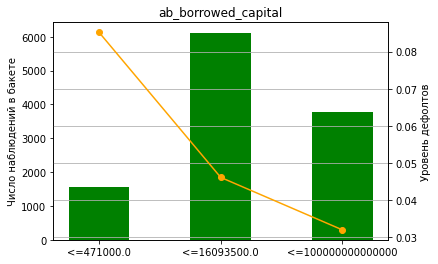

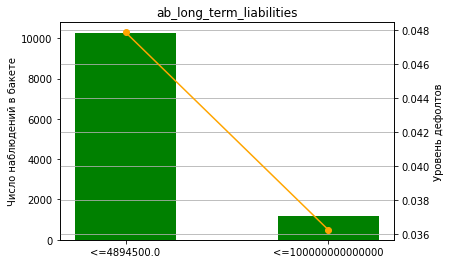

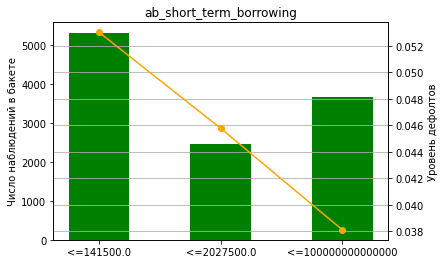

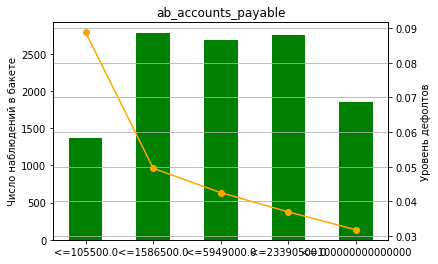

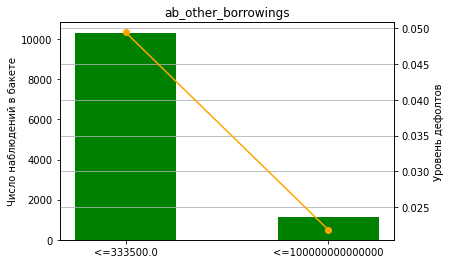

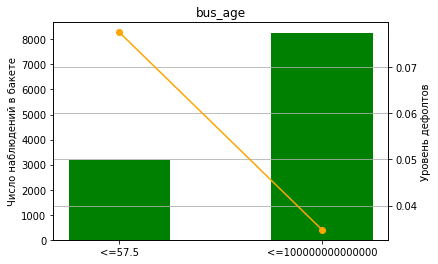

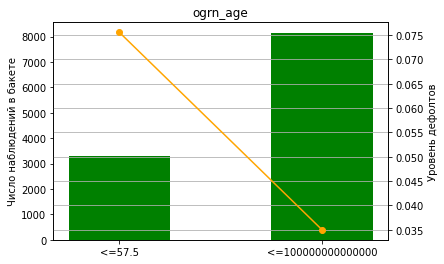

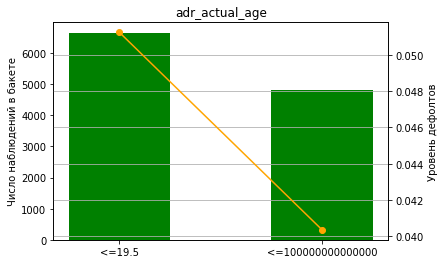

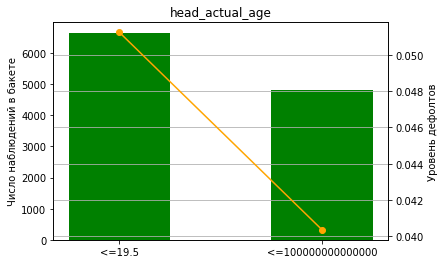

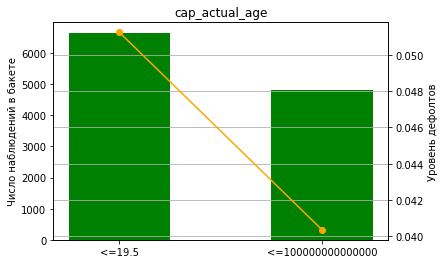

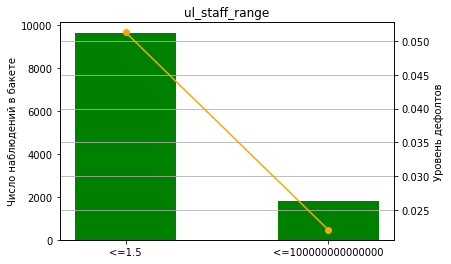

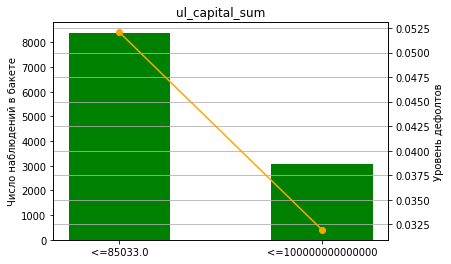

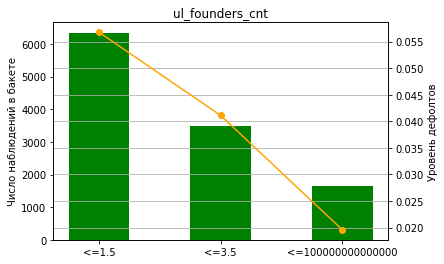

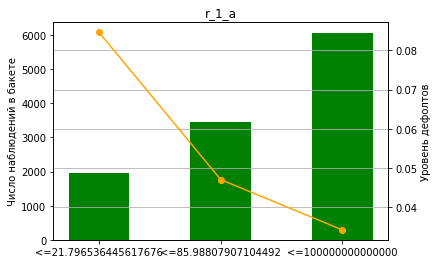

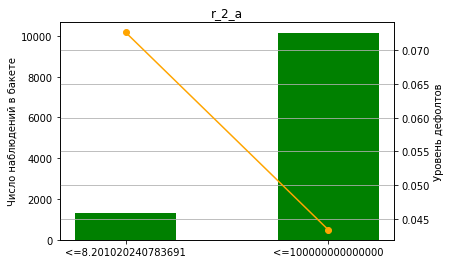

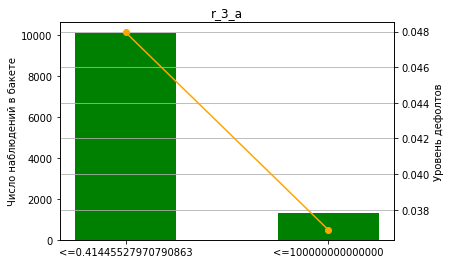

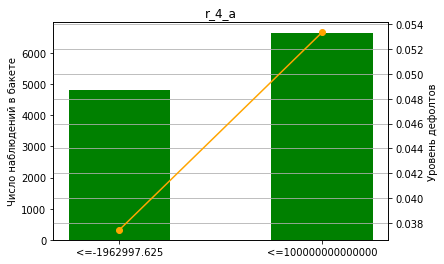

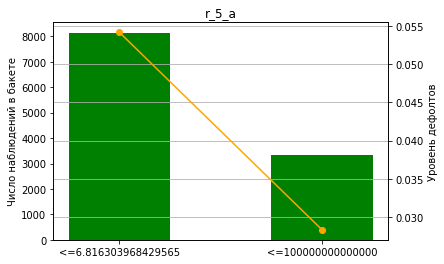

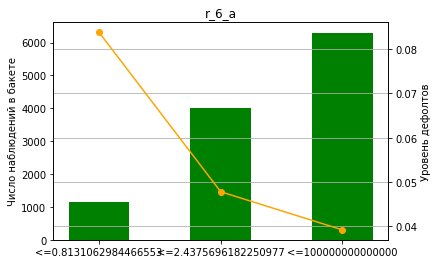

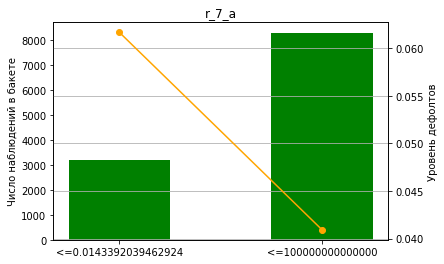

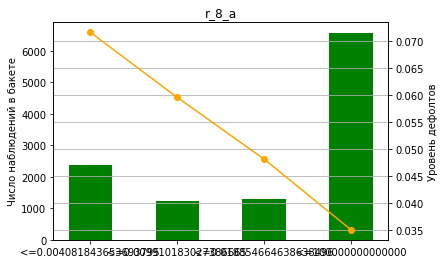

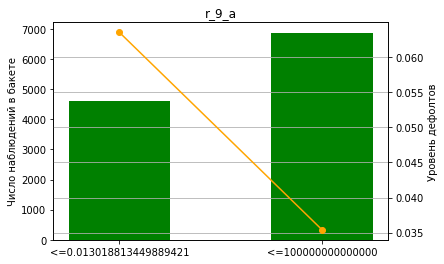

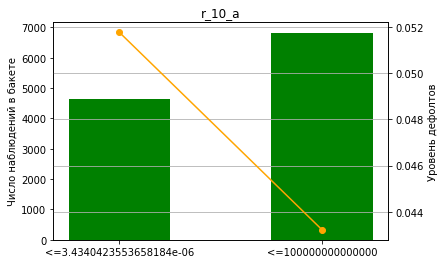

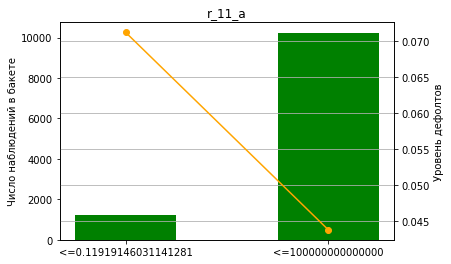

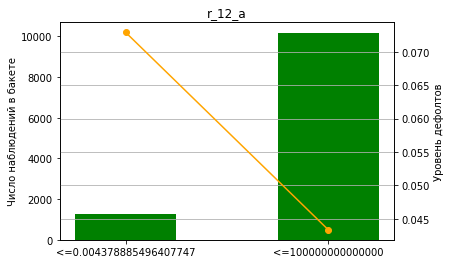

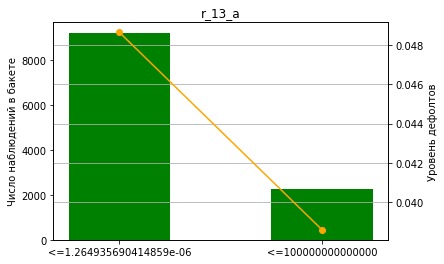

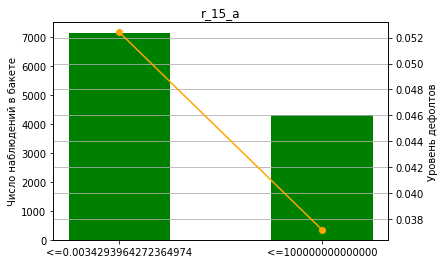

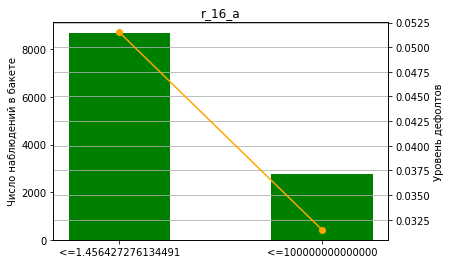

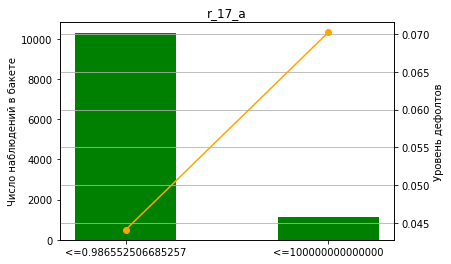

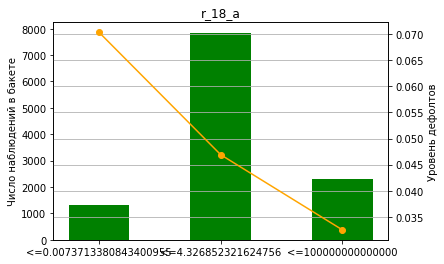

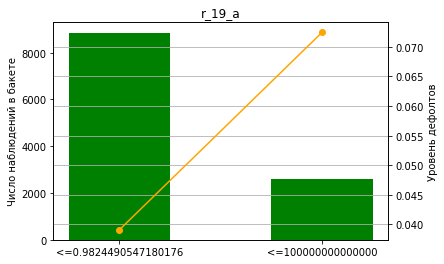

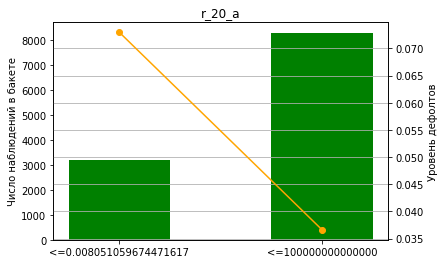

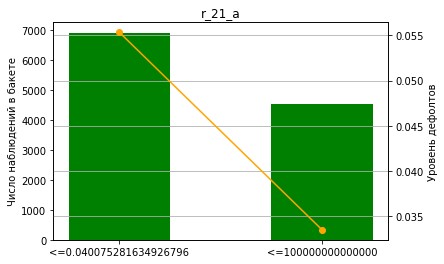

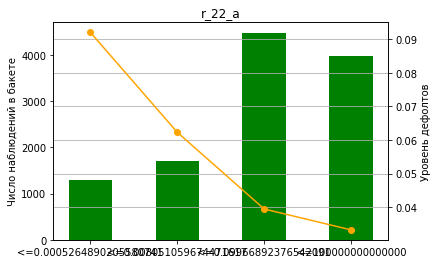

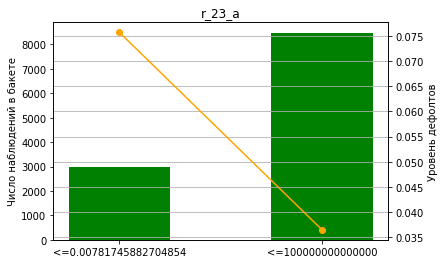

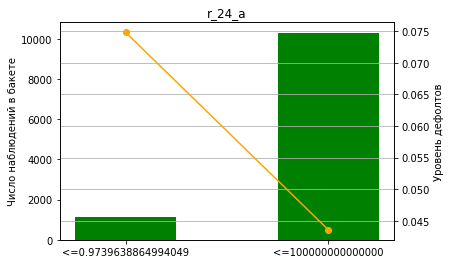

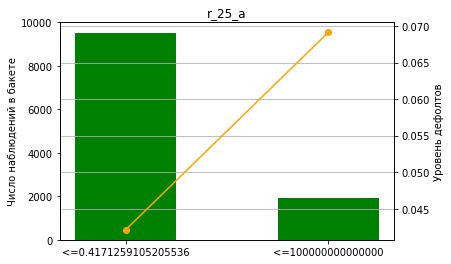

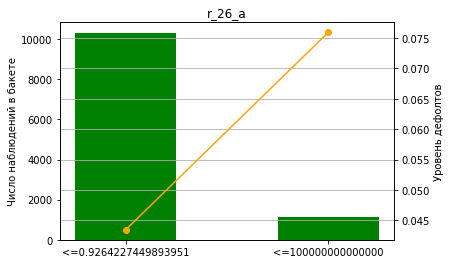

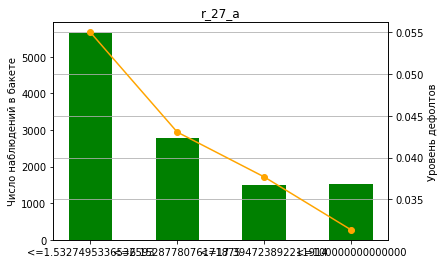

In [110]:
binning_barchart(bins)

### Отбор признаков

In [111]:
FEATURE_COUNT = 12

In [112]:
y_train_woe_ul = X_train_woe_ul['default_12m']
y_test_woe_ul = X_test_woe_ul['default_12m']
X_train_woe_ul.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_ul.drop(['default_12m'], axis = 1, inplace = True)

In [113]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT, 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_ul, y_train_woe_ul)

Выведем отобранные признаки:

In [114]:
selector.subsets_[FEATURE_COUNT]

{'feature_idx': (0, 6, 8, 10, 14, 16, 21, 22, 23, 24, 27, 39),
 'cv_scores': array([0.72799458, 0.71813096, 0.71643096]),
 'avg_score': 0.7208521699621492,
 'feature_names': ('ar_net_profit_woe',
  'ab_cash_and_securities_woe',
  'ab_own_capital_woe',
  'ab_long_term_liabilities_woe',
  'bus_age_woe',
  'adr_actual_age_woe',
  'ul_founders_cnt_woe',
  'r_1_a_woe',
  'r_2_a_woe',
  'r_3_a_woe',
  'r_6_a_woe',
  'r_19_a_woe')}

In [115]:
top_feat_ul = list(selector.subsets_[FEATURE_COUNT]['feature_names'])

Построим карту корреляций выбранных признаков. Проверим, чтобы между любыми двумя признаками не было высокой корреляции

In [116]:
X_train_woe_ul[top_feat_ul].corr()

,ar_net_profit_woe,ab_cash_and_securities_woe,ab_own_capital_woe,ab_long_term_liabilities_woe,bus_age_woe,adr_actual_age_woe,ul_founders_cnt_woe,r_1_a_woe,r_2_a_woe,r_3_a_woe,r_6_a_woe,r_19_a_woe
ar_net_profit_woe,1.000000,0.356387,0.702859,0.292458,0.244550,-0.026971,0.248271,0.182714,0.141222,0.053478,0.059143,0.012449
ab_cash_and_securities_woe,0.356387,1.000000,0.383771,0.156322,0.131458,0.001075,0.159804,0.226888,0.173492,0.056466,0.094336,0.476009
ab_own_capital_woe,0.702859,0.383771,1.000000,0.328376,0.446935,-0.029675,0.391417,0.242669,0.194044,0.048229,-0.014835,-0.005739
ab_long_term_liabilities_woe,0.292458,0.156322,0.328376,1.000000,0.126417,-0.038247,0.235187,0.109226,0.055271,0.117492,-0.040454,0.013717
bus_age_woe,0.244550,0.131458,0.446935,0.126417,1.000000,0.009713,0.218212,0.143217,0.135622,-0.039760,0.044573,0.003620
adr_actual_age_woe,-0.026971,0.001075,-0.029675,-0.038247,0.009713,1.000000,-0.069423,0.053520,0.020720,-0.014622,0.044221,0.002103
ul_founders_cnt_woe,0.248271,0.159804,0.391417,0.235187,0.218212,-0.069423,1.000000,0.169636,0.072415,0.005893,-0.040182,0.063644
r_1_a_woe,0.182714,0.226888,0.242669,0.109226,0.143217,0.053520,0.169636,1.000000,0.282926,0.063226,0.436665,0.076665
r_2_a_woe,0.141222,0.173492,0.194044,0.055271,0.135622,0.020720,0.072415,0.282926,1.000000,0.050192,0.435531,0.005639
r_3_a_woe,0.053478,0.056466,0.048229,0.117492,-0.039760,-0.014622,0.005893,0.063226,0.050192,1.000000,0.082342,-0.025094


Так как признак ab_own_capital сильно коррелирует с ar_net_profit, то удалим один из них

In [117]:
top_feat_ul.remove('ab_own_capital_woe')

In [118]:
X_train_woe_ul_final = X_train_woe_ul[top_feat_ul]
X_test_woe_ul_final = X_test_woe_ul[top_feat_ul]

Посчитаем коэффициент Джини для выбранных признаков

In [119]:
gini_features = pd.DataFrame(index=top_feat_ul, columns = ['Gini'])
for feat in top_feat_ul:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_ul_final.loc[:, feat].values.reshape(-1,1), y_train_woe_ul)
    preds_train = logreg.predict_proba((X_train_woe_ul_final.loc[:, feat].values.reshape(-1,1)))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_ul, preds_train) - 1

In [120]:
gini_features

,Gini
ar_net_profit_woe,0.304293
ab_cash_and_securities_woe,0.282631
ab_long_term_liabilities_woe,0.024321
bus_age_woe,0.193761
adr_actual_age_woe,0.059640
ul_founders_cnt_woe,0.146252
r_1_a_woe,0.190859
r_2_a_woe,0.066652
r_3_a_woe,0.025552
r_6_a_woe,0.120578


Признаки с Джини < 5% удаляем, так как у них низкая предсказательная способность.

In [121]:
top_feat_ul.remove('ab_long_term_liabilities_woe')
top_feat_ul.remove('r_3_a_woe')

In [122]:
X_train_woe_ul_final = X_train_woe_ul[top_feat_ul]
X_test_woe_ul_final = X_test_woe_ul[top_feat_ul]

### Подбираем коэффициент регуляризации

In [123]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_ul_final, y_train_woe_ul):
        
        X_train, X_test = X_train_woe_ul_final.iloc[train_index,:], X_train_woe_ul_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_ul.iloc[train_index], y_train_woe_ul.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

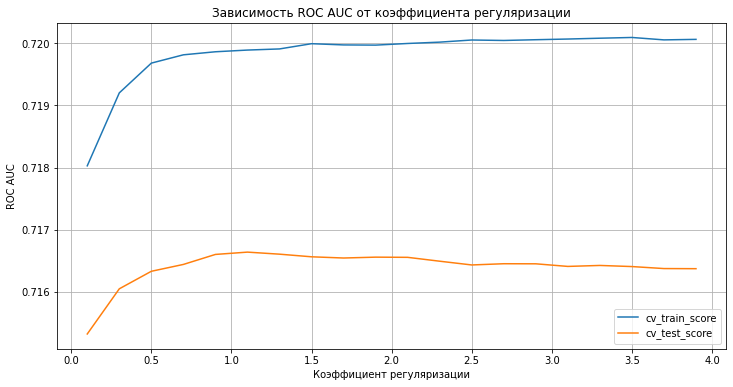

In [124]:
plt.plot(alphas, cv_scores_train, label = 'cv_train_score')
plt.plot(alphas, cv_scores_test, label = 'cv_test_score')
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.legend()
plt.title('Зависимость ROC AUC от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('ROC AUC')
plt.show()

In [125]:
print("Наилучший коэффициент регуляризации из рассмотренных:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент регуляризации из рассмотренных: 1.1000000000000003


Обучаем финальную модель на всех обучающих данных (без валидации)

In [126]:
logreg_ul = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.1)
logreg_ul.fit(X_train_woe_ul_final, y_train_woe_ul)
y_pred = logreg_ul.predict_proba(X_test_woe_ul_final)[:,1]
print("Gini val:", roc_auc_score(y_test_woe_ul, y_pred) * 2 - 1)

Gini val: 0.42091492354913873
